In [93]:
import pandas as pd
import config as c
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

In [94]:
data = pd.read_csv('data/runs/results.csv', index_col='run')

In [95]:
data = data[data['status']!='error']

In [96]:
data['time'] = pd.to_timedelta(data['time'])

In [97]:
data['seconds'] = data['time'].apply(lambda x:x.seconds)

In [98]:
data

,operation,started,time,status,label,ccle,ctrp,cutoff,drugs,feda,...,gdsc,metric,model,n,test,threshold,step,r_2_mean,r_2_std,seconds
run,,,,,,,,,,,,,,,,,,,,,
8bef89e3,train:train,2020-04-14 08:10:23,00:08:53,completed,ccle=yes ctrp=no cutoff=4 drugs=20 feda=no fs=...,True,False,4.0,20.0,False,...,True,AUC_IC50,ElasticNet,0.145363,NaN,0.01,0.0,0.341377,0.128184,533.0
970eb507,train:train,2020-04-14 08:10:19,00:00:02,completed,ccle=no ctrp=no cutoff=4 drugs=20 feda=yes fs=...,False,False,4.0,20.0,True,...,False,AUC_IC50,ElasticNet,0.024413,NaN,0.01,NaN,NaN,NaN,2.0
b8966f47,train:train,2020-04-14 07:59:59,00:10:16,completed,ccle=yes ctrp=no cutoff=4 drugs=20 feda=yes fs...,True,False,4.0,20.0,True,...,True,AUC_IC50,ElasticNet,0.173236,NaN,0.01,0.0,-0.011059,0.020281,616.0
fb10706c,train:train,2020-04-14 07:59:54,00:00:03,completed,ccle=no ctrp=no cutoff=4 drugs=20 feda=yes fs=...,False,False,4.0,20.0,True,...,False,AUC_EC50,ElasticNet,0.103103,NaN,0.01,NaN,NaN,NaN,3.0
b2e25dbb,train:train,2020-04-14 07:42:44,00:20:05,completed,ccle=no ctrp=no cutoff=4 drugs=20 feda=yes fs=...,False,False,4.0,20.0,True,...,True,AUC_IC50,ElasticNet,0.087834,NaN,0.01,0.0,0.108919,0.135117,1205.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31ccca5e,train:train,2020-04-08 22:01:59,00:00:01,completed,ccle=no ctrp=no cutoff=4 drugs=20 feda=no fs=f...,False,False,4.0,20.0,False,...,False,AUC_EC50,SVR,NaN,NaN,0.01,NaN,NaN,NaN,1.0
effa2da8,train:train,2020-04-08 21:59:25,00:02:33,completed,ccle=yes ctrp=yes cutoff=4 drugs=20 feda=no fs...,True,True,4.0,20.0,False,...,True,AUC_IC50,SVR,NaN,NaN,0.01,0.0,0.845099,0.112743,153.0
bb1ab338,train:train,2020-04-08 20:48:44,01:10:40,completed,ccle=yes ctrp=yes cutoff=4 drugs=20 feda=yes f...,True,True,4.0,20.0,True,...,True,AUC_IC50,SVR,NaN,NaN,0.10,0.0,-0.007567,0.010760,4240.0


In [103]:
data.groupby('model').mean()

,cutoff,drugs,n,test,threshold,step,r_2_mean,r_2_std,seconds
model,,,,,,,,,
ElasticNet,4.0,20.000000,0.101068,NaN,0.010000,0.0,0.161107,0.123685,1496.714765
RandomForestRegressor,4.0,19.900585,0.106795,NaN,0.010000,0.0,0.806358,0.019549,3646.461988
SVR,4.0,31.041152,0.125806,NaN,0.011276,0.0,0.148620,1.092171,1517.581590


In [49]:
(data['feda']).sum()

178

In [183]:
svr[svr['fs']=='ElasticNet'].describe()

,time,cutoff,drugs,n,test,threshold,step,r_2_mean,r_2_std,seconds
count,11,11.0,11.000000,11.000000,0.0,1.100000e+01,11.0,11.000000,11.000000,11.000000
mean,0 days 00:19:03.636363,4.0,45.727273,0.136338,NaN,1.000000e-02,0.0,0.484794,0.305416,1143.636364
std,0 days 00:10:47.727453,0.0,14.171033,0.075893,NaN,1.819393e-18,0.0,0.356741,0.262821,647.727454
min,0 days 00:00:40,4.0,3.000000,0.010000,NaN,1.000000e-02,0.0,0.007302,0.009792,40.000000
25%,0 days 00:12:14.500000,4.0,50.000000,0.073844,NaN,1.000000e-02,0.0,0.211647,0.169267,734.500000
50%,0 days 00:16:10,4.0,50.000000,0.144099,NaN,1.000000e-02,0.0,0.434479,0.293018,970.000000
75%,0 days 00:25:24,4.0,50.000000,0.200471,NaN,1.000000e-02,0.0,0.780054,0.328343,1524.000000
max,0 days 00:39:44,4.0,50.000000,0.234739,NaN,1.000000e-02,0.0,0.934915,1.008503,2384.000000


In [104]:
en = data[(data['model'] == 'ElasticNet') & (data['r_2_mean']>0)]
en[['feda', 'n', 'fs','r_2_mean']].sort_values('r_2_mean', ascending=False)

,feda,n,fs,r_2_mean
run,,,,
150587db,False,0.100081,mutual_info_regression,0.541867
140511c0,False,0.006392,DecisionTreeRegressor,0.502989
a0fd39fd,False,0.161861,DecisionTreeRegressor,0.479983
d122f81c,True,0.002680,DecisionTreeRegressor,0.445192
41a872e3,False,0.094544,RandomForestRegressor,0.439214
...,...,...,...,...
89c87159,True,0.187411,f_regression,0.041376
ccac81c4,False,0.099828,mutual_info_regression,0.036086
0485e171,False,0.066889,f_regression,0.032737


In [105]:
svr = data[(data['model'] == 'SVR') & (data['r_2_mean']>0)]
svr[svr['r_2_mean']> 0.6][['feda', 'n', 'fs','r_2_mean']].sort_values('r_2_mean', ascending=False)

,feda,n,fs,r_2_mean
run,,,,
c84c194d,False,0.010000,ElasticNet,0.934915
8071f94a,False,0.094795,DecisionTreeRegressor,0.922619
400d39b7,False,0.098271,DecisionTreeRegressor,0.922580
d2703cd1,False,0.147682,mutual_info_regression,0.919401
dfde6ba7,False,0.072084,mutual_info_regression,0.917935
c889fa24,False,0.087590,f_regression,0.916772
b1cea166,False,0.003354,mutual_info_regression,0.901983
e32273a7,False,0.144099,ElasticNet,0.897122
9cabe208,False,0.057282,RandomForestRegressor,0.887763


In [106]:
def append(data, run):
    result = pd.DataFrame()
    for a in run:
        f = subprocess.run("guild select " +a, shell=True, capture_output=True)
        d = pd.read_csv('venv/.guild/runs/'+f.stdout.decode('utf-8')[:-1]+'/scores.csv')
        d['run'] = [a for i in range(0, d.shape[0])]
        d = d.set_index('run')
        result = pd.concat([result, d])
    return result

In [107]:
k = append(en, en.index)

In [108]:
k

,Unnamed: 0,r2_score,mean_absolute_error,mean_squared_error,median_absolute_error,alpha,copy_X,fit_intercept,l1_ratio,max_iter,normalize,positive,precompute,random_state,selection,tol,warm_start
run,,,,,,,,,,,,,,,,,
8bef89e3,17-AAG,0.577536,0.160394,0.039363,0.128033,0.5,True,True,0.00,5000,False,False,False,NaN,cyclic,0.0001,False
8bef89e3,Crizotinib,0.285684,0.113119,0.024895,0.086993,0.5,True,True,0.00,5000,False,False,False,NaN,cyclic,0.0001,False
8bef89e3,Erlotinib,0.338793,0.123723,0.028159,0.089892,0.5,True,True,0.00,5000,False,False,False,NaN,cyclic,0.0001,False
8bef89e3,Lapatinib,0.425137,0.114108,0.024167,0.081929,0.5,True,True,0.00,5000,False,False,False,NaN,cyclic,0.0001,False
8bef89e3,Nilotinib,0.333835,0.096579,0.024252,0.060360,0.5,True,True,0.00,5000,False,False,False,NaN,cyclic,0.0001,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4e2d2666,Tacrolimus,0.155362,0.128648,0.024157,0.108298,0.1,True,True,0.00,1000,True,False,False,NaN,cyclic,0.0001,False
4e2d2666,UNC0321,0.079657,0.033905,0.001858,0.025878,0.1,True,True,0.00,1000,True,False,False,NaN,cyclic,0.0001,False
4e2d2666,VAF-347,-1.145587,0.057769,0.008091,0.046598,0.1,True,True,0.00,1000,True,False,False,NaN,cyclic,0.0001,False


In [84]:
k.groupby('normalize').mean()

,r2_score,mean_absolute_error,mean_squared_error,median_absolute_error,alpha,copy_X,fit_intercept,l1_ratio,max_iter,positive,precompute,random_state,tol,warm_start
normalize,,,,,,,,,,,,,,
False,0.300160,0.137149,0.032678,0.114441,0.787859,1.0,1.000000,0.012693,1000,0.0,0.0,NaN,0.0001,0.0
True,0.218647,0.124107,0.028921,0.107119,0.490850,1.0,0.496732,0.043301,1000,0.0,0.0,NaN,0.0001,0.0


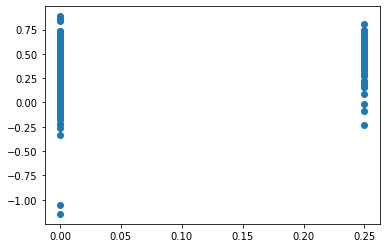

In [77]:
plt.scatter(k['l1_ratio'], k['r2_score'])